<a href="https://colab.research.google.com/github/rororoy/Learning-Machine-Learning/blob/main/MMN11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MMN 11 - ROY LAVROV - 322492059**
## **Handwritten Digit Classification**
### As stated in the guidelines the task is to train  our model on datasets of handwritten digits (0-9) to guess for an image the apropriate digit it represents.


---


### **Setting up and preperations:**

Importing usefull packages:


In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

> The MNIST dataset serves as a cornerstone in the domain of digit classification. It
comprises a collection of 28x28 pixel grayscale images, each depicting a handwritten
digit (0 through 9).



The training MNIST dataset split into two subsets of images:
* **60,000** - for training
* **10,000** - for testing

In [2]:
# Fetch MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist['data'], mnist['target']

samples = X.shape[0]
features = X.shape[1]

# Convert X into a matrix with bias (=1)
X = X.to_numpy()
X_with_bias = np.c_[X, np.ones(X.shape[0])]

# Convert string labels to integers
y = y.astype(int)

# Convert y into a matrix
y = y.to_numpy()

# Convert y into a matrix of one hot vectors
y_onehot = np.zeros((samples, 10), dtype=int)
y_onehot[np.arange(samples), y] = 1

# Split into training and testing sets (60,000 for training, 10,000 for testing)
X_train, X_test, y_train_onehot, y_test_onehot = train_test_split(
    X_with_bias, y_onehot, train_size=60000, test_size=10000, random_state=42)

# Crearing a signed y set with values [-1,1]
y_signed_train = np.where(y_train_onehot == 1, 1, -1)
y_signed_test = np.where(y_test_onehot == 1, 1, -1)

### **Utils**

In [3]:
def compare_models(binary_metrics, multiclass_metrics):
  """Compare binary and multiclass perceptron performances with aligned visualizations."""
  metrics = ['Accuracy', 'Sensitivity', 'Selectivity']

  # Prepare data for comparison
  binary_avgs = [np.mean(binary_metrics[metric]) for metric in metrics]
  multi_avgs = [np.mean(multiclass_metrics[metric]) for metric in metrics]

  # Set consistent figure size for both visualizations
  fig_width = 12

  # Create bar chart
  plt.figure(figsize=(fig_width, 6))

  x = np.arange(len(metrics))
  width = 0.35

  plt.bar(x - width/2, binary_avgs, width, label='Individual Perceptrons (Avg)')
  plt.bar(x + width/2, multi_avgs, width, label='MultiClass Perceptron')

  plt.xlabel('Metric')
  plt.ylabel('Score')
  plt.title('Performance Comparison: Individual vs. MultiClass Perceptrons')
  plt.xticks(x, metrics)
  plt.ylim(0, 1)
  plt.legend()
  plt.grid(axis='y', linestyle='--', alpha=0.7)

  # Add value annotations
  for i, v in enumerate(binary_avgs):
    plt.text(i - width/2, v + 0.02, f'{v:.4f}', ha='center')

  for i, v in enumerate(multi_avgs):
    plt.text(i + width/2, v + 0.02, f'{v:.4f}', ha='center')

  plt.tight_layout()
  plt.show()

  # Create table visualization with the same width
  fig, ax = plt.subplots(figsize=(fig_width, 3))
  ax.axis('off')
  ax.axis('tight')

  table_data = [
      ['Metric', 'Individual Perceptrons (Avg)', 'MultiClass Perceptron', 'Difference'],
  ]

  for i, metric in enumerate(metrics):
    diff = binary_avgs[i] - multi_avgs[i]
    table_data.append([
      metric,
      f'{binary_avgs[i]:.4f}',
      f'{multi_avgs[i]:.4f}',
      f'{diff:.4f}'
    ])

  table = ax.table(cellText=table_data, loc='center', cellLoc='center')
  table.auto_set_font_size(False)
  table.set_fontsize(12)
  table.scale(1, 1.5)

  # Style the header row
  for i in range(4):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(color='white')

  plt.title('Performance Metrics Comparison', y=0.8, fontsize=14)
  plt.tight_layout()
  plt.show()

# **Part A: Perceptron**
### **We define the single Perceptron class that will be trained individually to correctly predict a given target digit as one vs all.**
* We track the history of the best performing weights (starting with W = 0) to track the one with the best accurecy one as per the pocket algorithem
* The model determines the better weight to use based on what the error rate is by calculating the proportion of examples that were misclassified

In [ ]:
class Perceptron:
  def __init__(self, n_features=785, target_digit=None, max_iterations=1000, learning_rate=1.0):
    self.n_features = n_features
    self.target_digit = target_digit
    self.max_iterations = max_iterations
    self.learning_rate = learning_rate
    self.W = None
    self.pocket_history = []

  def fit(self, X, y_signed):
    # Extract relevant column for this perceptron's target digit
    y = y_signed[:, self.target_digit]

    # Initialize weights
    self.W = np.zeros(self.n_features)
    best_W = self.W.copy()
    best_error = float('inf')

    for iteration in tqdm(range(self.max_iterations), desc= f'train with pocket algo'):
      # Get current predictions
      y_pred = self.predict(X)

      # Find misclassified examples
      misclassified_indices = np.where(y_pred != y)[0]

      # If no misclassified examples, we're done
      if len(misclassified_indices) == 0:
        print(f"Perceptron for digit {self.target_digit} converged after {iteration+1} iterations!")
        break

      # Randomly choose a misclassified example
      idx = np.random.choice(misclassified_indices)

      # Update weights
      self.W = self.W + self.learning_rate * y[idx] * X[idx]

      # Calculate current error
      current_error = np.mean(self.predict(X) != y)

      # Update pocket weights if improved
      if current_error < best_error:
        best_W = self.W.copy()
        best_error = current_error

        # Record pocket weights and error
        self.pocket_history.append((iteration + 1, best_W.copy(), best_error))

    # Use the best weights found
    self.W = best_W
    return self


  def predict(self, X):
    return np.sign(X @ self.W)

  def confidence_scores(self, X):
    return X @ self.W

  def calculate_accuracy(self, X, y):
    y_pred = self.predict(X)
    return np.mean(y_pred == y)

  def Ein(self, X, y):
    y_pred = self.predict(X)
    return np.mean(y_pred != y)

### **Now to strengthen the case of the weakness of the later multi class percepton we'll train the perceptron individually for each class and analyze the performance digit by digit**
The results of the individual tests and analysis of the average accurecy and sensetivity will point out the efficiency of the models' predictions when we use the perceptron on each digit individually: one digit vs all


=== Training perceptron for digit 0 ===


train with pocket algo:   0%|          | 0/700 [00:00<?, ?it/s]

Accuracy: 0.9886
Sensitivity (TPR): 0.9278
Selectivity (TNR): 0.9952

=== Training perceptron for digit 1 ===


train with pocket algo:   0%|          | 0/700 [00:00<?, ?it/s]

Accuracy: 0.9916
Sensitivity (TPR): 0.9566
Selectivity (TNR): 0.9962

=== Training perceptron for digit 2 ===


train with pocket algo:   0%|          | 0/700 [00:00<?, ?it/s]

Accuracy: 0.9750
Sensitivity (TPR): 0.8687
Selectivity (TNR): 0.9864

=== Training perceptron for digit 3 ===


train with pocket algo:   0%|          | 0/700 [00:00<?, ?it/s]

Accuracy: 0.9629
Sensitivity (TPR): 0.7631
Selectivity (TNR): 0.9859

=== Training perceptron for digit 4 ===


train with pocket algo:   0%|          | 0/700 [00:00<?, ?it/s]

Accuracy: 0.9795
Sensitivity (TPR): 0.8940
Selectivity (TNR): 0.9880

=== Training perceptron for digit 5 ===


train with pocket algo:   0%|          | 0/700 [00:00<?, ?it/s]

Accuracy: 0.9618
Sensitivity (TPR): 0.7321
Selectivity (TNR): 0.9855

=== Training perceptron for digit 6 ===


train with pocket algo:   0%|          | 0/700 [00:00<?, ?it/s]

Accuracy: 0.9839
Sensitivity (TPR): 0.9053
Selectivity (TNR): 0.9923

=== Training perceptron for digit 7 ===


train with pocket algo:   0%|          | 0/700 [00:00<?, ?it/s]

Accuracy: 0.9816
Sensitivity (TPR): 0.8749
Selectivity (TNR): 0.9942

=== Training perceptron for digit 8 ===


train with pocket algo:   0%|          | 0/700 [00:00<?, ?it/s]

Accuracy: 0.9381
Sensitivity (TPR): 0.5181
Selectivity (TNR): 0.9832

=== Training perceptron for digit 9 ===


train with pocket algo:   0%|          | 0/700 [00:00<?, ?it/s]

Accuracy: 0.9513
Sensitivity (TPR): 0.7500
Selectivity (TNR): 0.9746


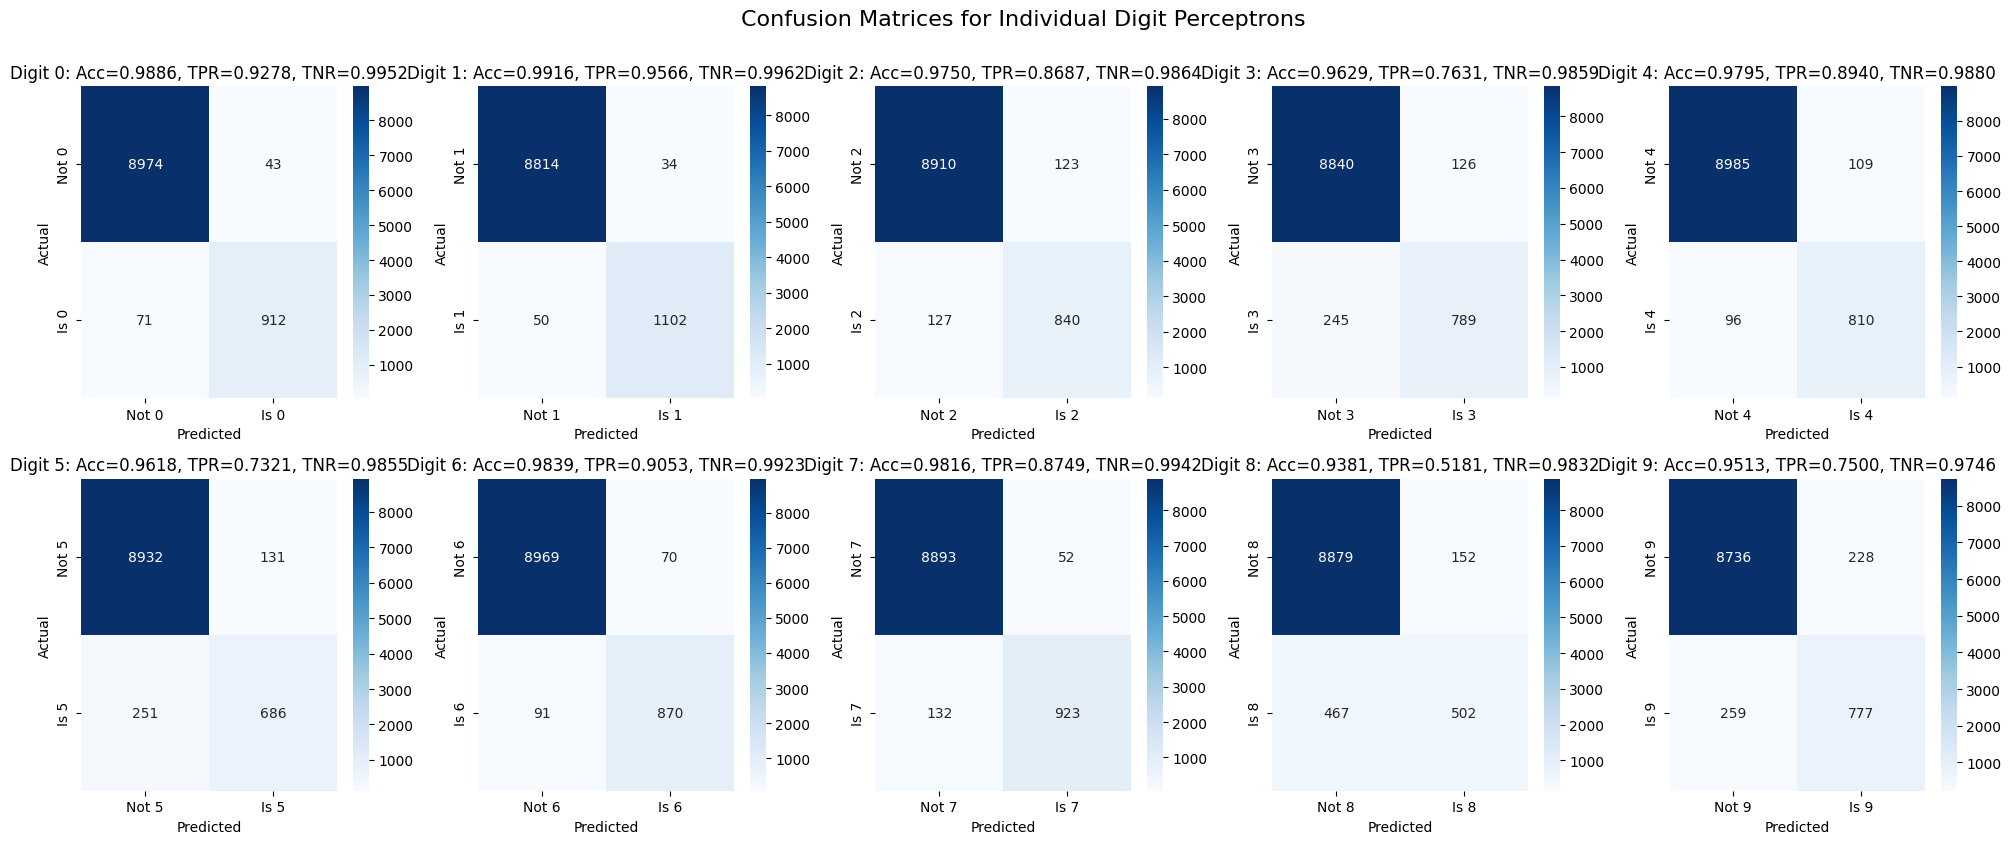

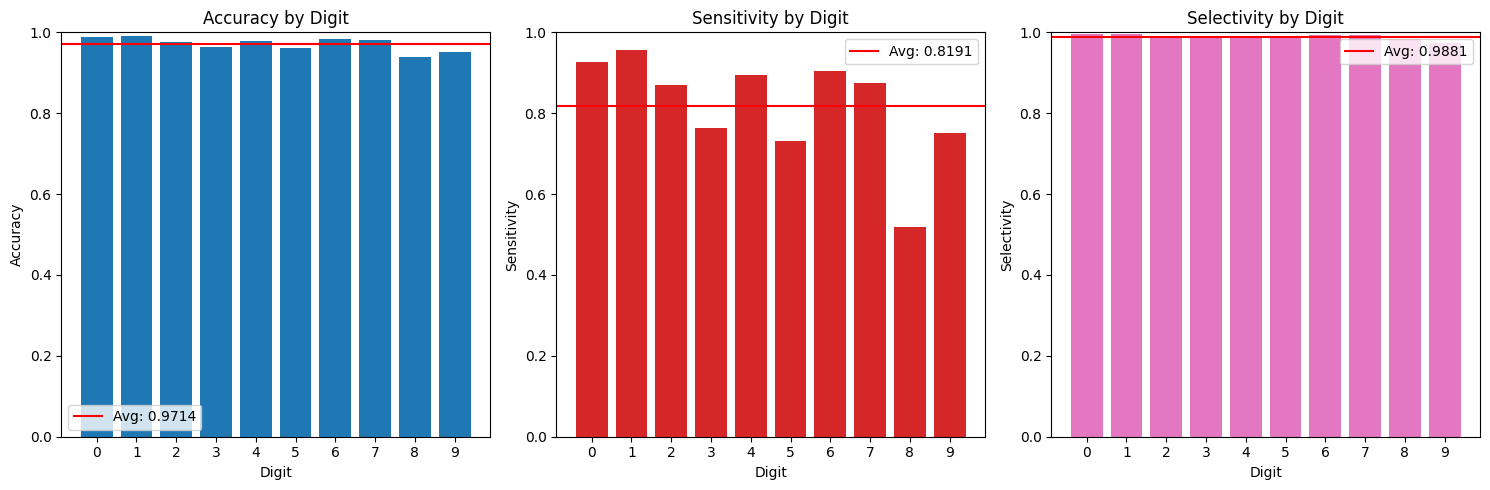


=== Summary ===
Digit  |  Accuracy  |  Sensitivity  |  Selectivity
--------------------------------------------------
  0    |   0.9886   |   0.9278   |   0.9952
  1    |   0.9916   |   0.9566   |   0.9962
  2    |   0.9750   |   0.8687   |   0.9864
  3    |   0.9629   |   0.7631   |   0.9859
  4    |   0.9795   |   0.8940   |   0.9880
  5    |   0.9618   |   0.7321   |   0.9855
  6    |   0.9839   |   0.9053   |   0.9923
  7    |   0.9816   |   0.8749   |   0.9942
  8    |   0.9381   |   0.5181   |   0.9832
  9    |   0.9513   |   0.7500   |   0.9746

Average accuracy: 0.9714
Average sensitivity: 0.8191
Average selectivity: 0.9881


In [ ]:
def train_and_evaluate_all_digits(X_train, y_signed_train, X_test, y_signed_test, max_iterations=700):
    """Train and evaluate individual perceptrons for each digit."""
    # Store results
    accuracies = []
    sensitivities = []
    selectivities = []
    all_conf_matrices = []

    # Train and evaluate a perceptron for each digit
    for digit in range(10):
        print(f"\n=== Training perceptron for digit {digit} ===")

        # Create and train perceptron
        perceptron = Perceptron(n_features=X_train.shape[1], target_digit=digit, max_iterations=max_iterations)
        perceptron.fit(X_train, y_signed_train)

        # Get predictions
        y_pred = perceptron.predict(X_test)
        y_true = y_signed_test[:, digit]

        # Calculate accuracy
        accuracy = np.mean(y_pred == y_true)
        accuracies.append(accuracy)

        # Create confusion matrix
        true_pos = np.sum((y_pred == 1) & (y_true == 1))
        true_neg = np.sum((y_pred == -1) & (y_true == -1))
        false_pos = np.sum((y_pred == 1) & (y_true == -1))
        false_neg = np.sum((y_pred == -1) & (y_true == 1))

        conf_matrix = np.array([
            [true_neg, false_pos],
            [false_neg, true_pos]
        ])
        all_conf_matrices.append(conf_matrix)

        # Calculate sensitivity (true positive rate)
        sensitivity = true_pos / (true_pos + false_neg) if (true_pos + false_neg) > 0 else 0
        sensitivities.append(sensitivity)

        # Calculate selectivity (true negative rate)
        selectivity = true_neg / (true_neg + false_pos) if (true_neg + false_pos) > 0 else 0
        selectivities.append(selectivity)

        # Print metrics
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Sensitivity (TPR): {sensitivity:.4f}")
        print(f"Selectivity (TNR): {selectivity:.4f}")

    # Organize metrics
    metrics = {
        'Accuracy': accuracies,
        'Sensitivity': sensitivities,
        'Selectivity': selectivities
    }

    # Visualize results
    plot_binary_confusion_matrices(all_conf_matrices, accuracies, sensitivities, selectivities)
    plot_metrics_by_digit(metrics)

    # Print summary table
    print("\n=== Summary ===")
    print("Digit  |  Accuracy  |  Sensitivity  |  Selectivity")
    print("--------------------------------------------------")
    for i in range(10):
        print(f"  {i}    |   {accuracies[i]:.4f}   |   {sensitivities[i]:.4f}   |   {selectivities[i]:.4f}")

    print(f"\nAverage accuracy: {np.mean(accuracies):.4f}")
    print(f"Average sensitivity: {np.mean(sensitivities):.4f}")
    print(f"Average selectivity: {np.mean(selectivities):.4f}")

    return metrics, all_conf_matrices

# Running the training and evaluation
binary_metrics, binary_conf_matrices = train_and_evaluate_all_digits(X_train, y_signed_train, X_test, y_signed_test)

### **Analyzing result**

These results will help us analyze the multi class perceptron

---
### **Defining the multi class perceptron**
The multi class perceptron trains all single perceptrons on each digit [0..9] once at a time.
For a new instance x, the prediction of the label is determined by selecting the class with the highest confidence score: *ŷ=argmax{Wʸx} yϵ{0,...,9}*

In [ ]:
class MultiClassPerceptron:
  def __init__(self, n_features=785, n_classes=10, max_iterations=1000, learning_rate=1.0):
    self.n_features = n_features
    self.n_classes = n_classes
    self.max_iterations = max_iterations
    self.learning_rate = learning_rate
    self.perceptrons = []

  def fit(self, X, y_signed):
    self.perceptrons = []

    # Train a perceptron for each digit
    for digit in range(self.n_classes):
      print(f"\nTraining perceptron for digit {digit}")
      perceptron = Perceptron(
        n_features=self.n_features,
        target_digit=digit,
        max_iterations=self.max_iterations,
        learning_rate=self.learning_rate
      )
      perceptron.fit(X, y_signed)
      self.perceptrons.append(perceptron)

    return self

  def predict(self, X):
    # Get confidence scores from all perceptrons
    scores = np.zeros((X.shape[0], self.n_classes))

    for digit, perceptron in enumerate(self.perceptrons):
        scores[:, digit] = perceptron.confidence_scores(X)

    # Return the digit with the highest confidence score for each sample
    return np.argmax(scores, axis=1)

  def confidence_matrix(self, X):
    scores = np.zeros((X.shape[0], self.n_classes))

    for digit, perceptron in enumerate(self.perceptrons):
        scores[:, digit] = perceptron.confidence_scores(X)

    return scores

  def accuracy(self, X, y_true):
    # Convert one-hot encoded labels to digit indices if needed
    if y_true.ndim > 1 and y_true.shape[1] > 1:
        y_true = np.argmax(y_true, axis=1)

    # Make predictions and calculate accuracy
    y_pred = self.predict(X)
    return np.mean(y_pred == y_true)

  def confusion_matrix(self, X, y_true):
    # Convert one-hot encoded labels to digit indices if needed
    if y_true.ndim > 1 and y_true.shape[1] > 1:
        y_true = np.argmax(y_true, axis=1)

    # Make predictions
    y_pred = self.predict(X)

    # Create confusion matrix
    conf_matrix = np.zeros((self.n_classes, self.n_classes), dtype=int)
    for i in range(len(y_true)):
        conf_matrix[y_true[i], y_pred[i]] += 1

    return conf_matrix

  def sensitivity_per_class(self, X, y_true):
    conf_matrix = self.confusion_matrix(X, y_true)
    sensitivities = np.zeros(self.n_classes)

    for i in range(self.n_classes):
      # Sensitivity = true positives / (true positives + false negatives)
      # True positives are on the diagonal of the confusion matrix
      true_positives = conf_matrix[i, i]
      # All actual positives are the sum of this row
      actual_positives = np.sum(conf_matrix[i, :])

      if actual_positives > 0:
        sensitivities[i] = true_positives / actual_positives

    return sensitivities

### **Training the multi class perceptron:**
We will run the multiclass perceptron on our training data set and test the results on our testing batch to get info on the effectiveness of the multi class model approach

=== Training MultiClass Perceptron ===

Training perceptron for digit 0


train with pocket algo:   0%|          | 0/700 [00:00<?, ?it/s]


Training perceptron for digit 1


train with pocket algo:   0%|          | 0/700 [00:00<?, ?it/s]


Training perceptron for digit 2


train with pocket algo:   0%|          | 0/700 [00:00<?, ?it/s]


Training perceptron for digit 3


train with pocket algo:   0%|          | 0/700 [00:00<?, ?it/s]


Training perceptron for digit 4


train with pocket algo:   0%|          | 0/700 [00:00<?, ?it/s]


Training perceptron for digit 5


train with pocket algo:   0%|          | 0/700 [00:00<?, ?it/s]


Training perceptron for digit 6


train with pocket algo:   0%|          | 0/700 [00:00<?, ?it/s]


Training perceptron for digit 7


train with pocket algo:   0%|          | 0/700 [00:00<?, ?it/s]


Training perceptron for digit 8


train with pocket algo:   0%|          | 0/700 [00:00<?, ?it/s]


Training perceptron for digit 9


train with pocket algo:   0%|          | 0/700 [00:00<?, ?it/s]


MultiClass Perceptron Accuracy: 0.8918

Metrics for each digit:
Digit  |  Sensitivity  |  Selectivity
----------------------------------
  0    |   0.9583   |   0.9951
  1    |   0.9609   |   0.9947
  2    |   0.8697   |   0.9875
  3    |   0.8743   |   0.9849
  4    |   0.8675   |   0.9893
  5    |   0.8239   |   0.9862
  6    |   0.9490   |   0.9911
  7    |   0.9242   |   0.9878
  8    |   0.8050   |   0.9792
  9    |   0.8678   |   0.9839

Average Sensitivity: 0.8901
Average Selectivity: 0.9880


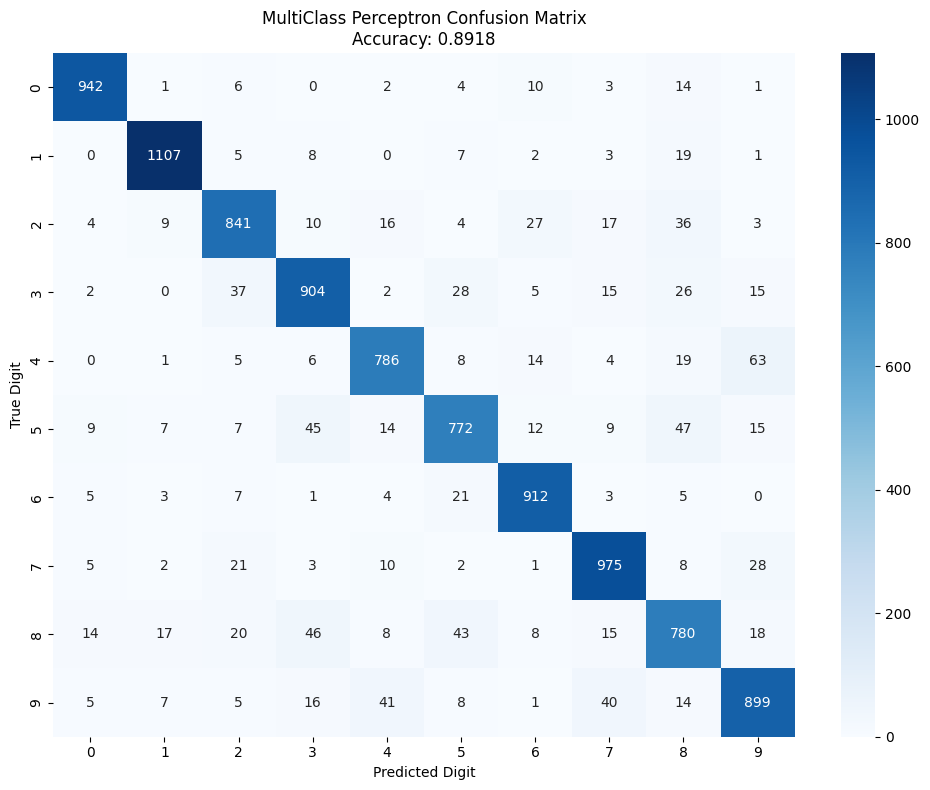

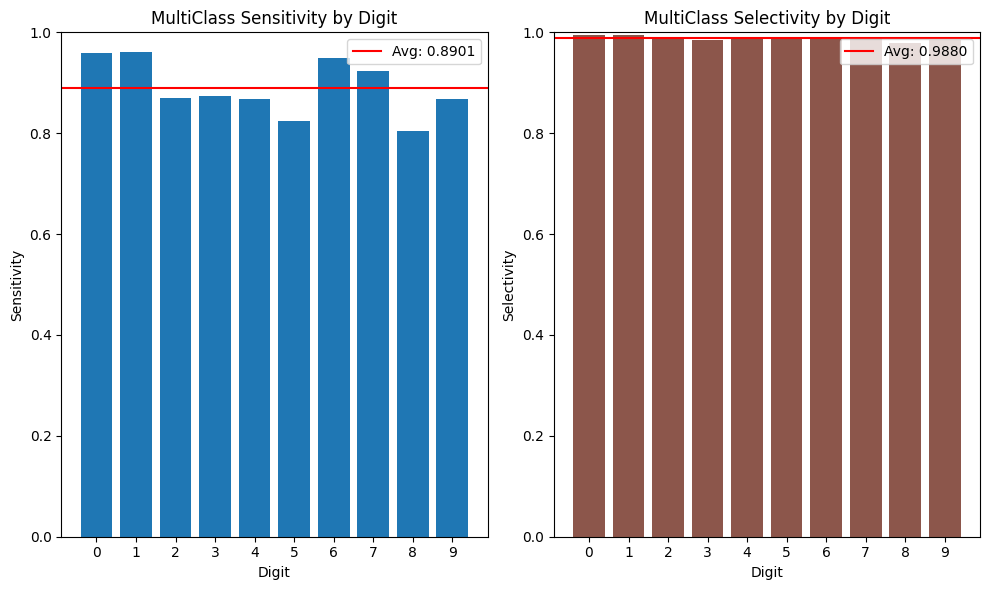

In [ ]:
def train_and_evaluate_multiclass_perceptron(X_train, y_signed_train, X_test, y_test_onehot, max_iterations=700):
    """Train and evaluate multiclass perceptron."""
    print("=== Training MultiClass Perceptron ===")

    # Create and train the MultiClassPerceptron
    model = MultiClassPerceptron(n_features=X_train.shape[1], n_classes=10, max_iterations=max_iterations)
    model.fit(X_train, y_signed_train)

    # Make predictions on test data
    y_pred = model.predict(X_test)
    y_true = np.argmax(y_test_onehot, axis=1)

    # Calculate overall accuracy
    accuracy = np.mean(y_pred == y_true)
    print(f"\nMultiClass Perceptron Accuracy: {accuracy:.4f}")

    # Generate confusion matrix
    conf_matrix = np.zeros((10, 10), dtype=int)
    for i in range(len(y_true)):
        conf_matrix[y_true[i], y_pred[i]] += 1

    # Calculate sensitivity and selectivity for each digit
    sensitivities = np.zeros(10)
    selectivities = np.zeros(10)

    for i in range(10):
        # Sensitivity = TP / (TP + FN)
        # For digit i, TP is conf_matrix[i,i]
        # Sum of row i is all samples that should be classified as i
        sensitivities[i] = conf_matrix[i, i] / np.sum(conf_matrix[i, :]) if np.sum(conf_matrix[i, :]) > 0 else 0

        # Selectivity (TNR) = TN / (TN + FP)
        # For multiclass, this is a bit different:
        # TN = all samples not from class i that were not predicted as i
        # FP = all samples not from class i that were predicted as i
        total_not_i = len(y_true) - np.sum(conf_matrix[i, :])  # All samples not from class i
        false_pos_i = np.sum(conf_matrix[:, i]) - conf_matrix[i, i]  # All predicted as i minus true positives
        true_neg_i = total_not_i - false_pos_i

        selectivities[i] = true_neg_i / total_not_i if total_not_i > 0 else 0

    # Organize metrics
    metrics = {
        'Accuracy': [accuracy] * 10,  # Same accuracy for all digits in multiclass
        'Sensitivity': sensitivities,
        'Selectivity': selectivities
    }

    # Print metrics
    print("\nMetrics for each digit:")
    print("Digit  |  Sensitivity  |  Selectivity")
    print("----------------------------------")
    for digit in range(10):
        print(f"  {digit}    |   {sensitivities[digit]:.4f}   |   {selectivities[digit]:.4f}")

    print(f"\nAverage Sensitivity: {np.mean(sensitivities):.4f}")
    print(f"Average Selectivity: {np.mean(selectivities):.4f}")

    # Visualize results
    plot_multiclass_confusion_matrix(conf_matrix, accuracy)
    plot_multiclass_metrics({'Sensitivity': sensitivities, 'Selectivity': selectivities})

    return model, metrics, conf_matrix

# Running the training and evaluation
model, multiclass_metrics, multiclass_conf_matrix = train_and_evaluate_multiclass_perceptron(X_train, y_signed_train, X_test, y_test_onehot)

---
## **Comparasion and conclusion**
We started by trainining and testing the signle perceptron on each digit individually in a one vs all approach to correctly clasify each digit

In this approach all models are seperated and do not function to predict as wanted, therfore we implement the multi class perceptron:

Training the perceptrons again and determining the best confidence score to determine the class the full model is more sure of in classifying and predicting the data

We can summarize the results of the two models to deduce our insights into the strengths and weaknesses of the multi class model:


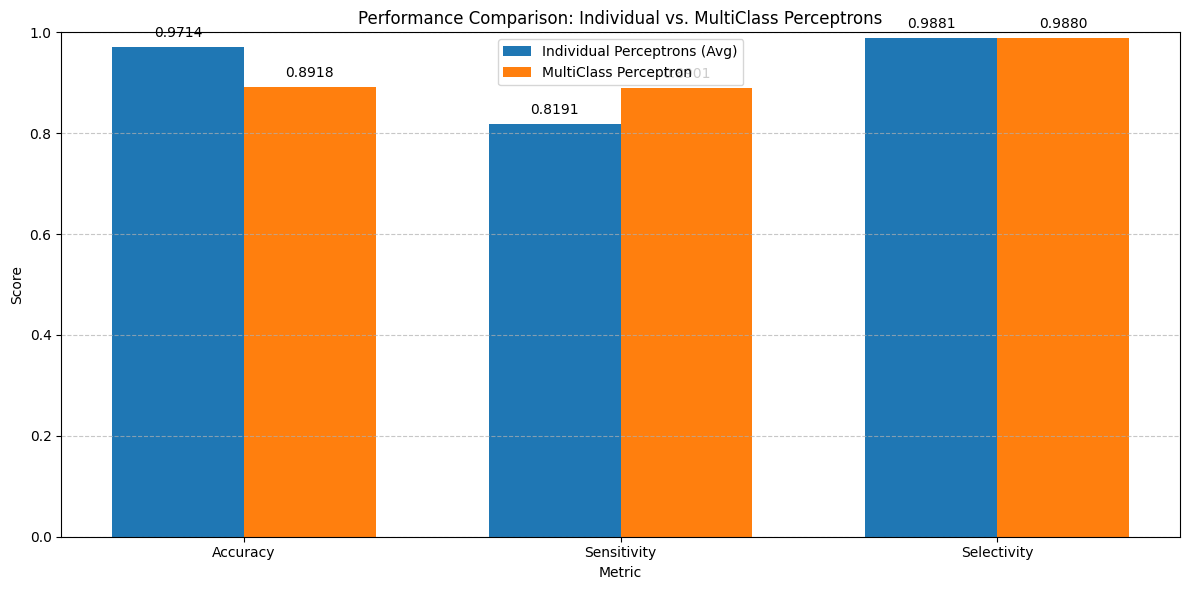

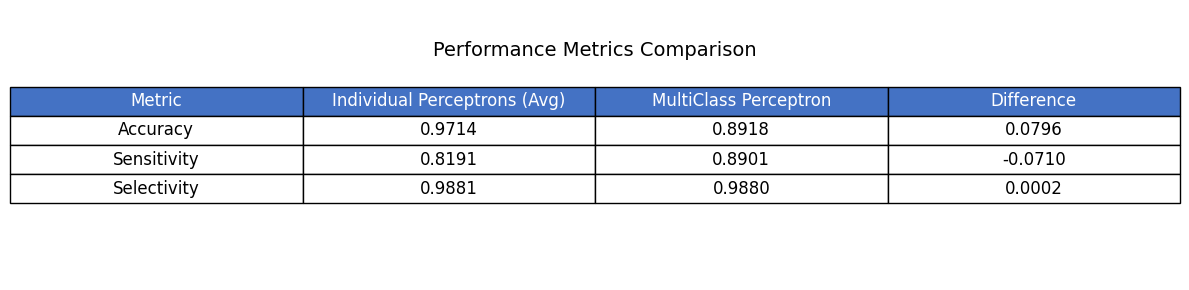

In [ ]:
# Compare the models
compare_models(binary_metrics, multiclass_metrics)

####**Summery of the perceptron descussion**

##### **Accuracy:** Analyzing the data above we can see a major trade off in accuracy when we implement a multi class perceptron. By implementing a perceptron that tries to predict the data by deciding based on the highest confidence score (using the argmax method) the accuracy is reduced greatly (by ~10%-7%) and fails to utilize the potential of the high accuracy achieved by all individual perceptrons.

##### **Limitations of Linear Boundaries:** The 89.18% accuracy (rather than higher) reflects the inherent limitations of perceptrons even with the pocket algorithm, which can only form linear decision boundaries. This suggests some digit classes aren't perfectly linearly separable from others (compared to other models).

##### **High Selectivity scores (TNR):** Very effective at correctly identifying negative cases, resulting in few false positives.

##### **Simplicity:** The rather simple implementation of the perceptron and the multi class perceptron is a positive considering the "alright" results of accuracy we achieve with such a model.

##### **Speed:** Knowing the big trade off we get in accuracy of correctly identified classes - the long running times (7-8m) in training and testing that are needed for the perceptron are too slow knowing the rather low accuracy we are getting.

# **Part B: Softmax Regression**
### **We define the Logistic Regression model class**
* The model utilizes softmax as the activation function to determine the propability in correctly classifying the class in a multi class problem
* We will control the model using two **hyperparameters**: epochs and learning rate(lr)

In [24]:
class LogisticRegression:
    def __init__(self, input_dim, num_classes, learning_rate=0.1):
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.learning_rate = learning_rate

        self._W = None

        # For tracking performance
        self.train_loss_history = []
        self.test_loss_history = []

    def softmax(self, score):
        # For numerical stability - subtract the row-wise max of exps
        shifted_score = score - np.max(score, axis=1, keepdims=True)

        exp_scores = np.exp(shifted_score)
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    def predict_proba(self, X):
        scores = np.dot(X, self._W)
        return self.softmax(scores)

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

    def cross_entropy_loss(self, X, y):
        P_hat = self.predict_proba(X)

        # To avoid log(0) - ensure probabilities are in the range [ε, 1-ε]
        epsilon = 1e-15
        P_hat_clipped = np.clip(P_hat, epsilon, 1 - epsilon)

        # y is one-hot encoded, so multiplying it element-wise is equivalent to I[Yn=k]
        loss = -np.mean(y * np.log(P_hat_clipped))
        return loss

    def compute_gradient(self, X, y):
        # Get predicted probabilities
        P_hat = self.predict_proba(X)

        # Gradient: X^T · (P_hat - y) / n_samples
        error = P_hat - y
        gradient = np.dot(X.T, error) / X.shape[0]

        return gradient

    def fit(self, X_train, y_train, X_test, y_test, epochs=100, batch_size=None, verbose=True):
        n_samples = X_train.shape[0]

        # Reset history
        self.train_loss_history = []
        self.test_loss_history = []

        n_features = X_train.shape[1]
        n_classes = self.num_classes

        # Generate weights with normal distribution
        self._W = np.random.normal(0, 0.01, (n_features, n_classes))

        # Truncate extreme values (e.g., beyond 2 standard deviations)
        threshold = 1.5*0.01
        self._W = np.clip(self._W, -threshold, threshold)

        # Initialize progress bar if verbose
        if verbose:
            epochs_range = tqdm(range(epochs), desc="Training")
        else:
            epochs_range = range(epochs)

        for epoch in epochs_range:
            # Full batch gradient descent
            if batch_size is None:
                # Compute gradient
                gradient = self.compute_gradient(X_train, y_train)

                # Update weights
                self._W -= self.learning_rate * gradient

            # Mini-batch gradient descent
            else:
                # Shuffle data
                indices = np.random.permutation(n_samples)
                X_shuffled = X_train[indices]
                y_shuffled = y_train[indices]

                # Process mini-batches
                for i in range(0, n_samples, batch_size):
                    end_idx = min(i + batch_size, n_samples)
                    X_batch = X_shuffled[i:end_idx]
                    y_batch = y_shuffled[i:end_idx]

                    # Compute gradient on mini-batch
                    gradient = self.compute_gradient(X_batch, y_batch)

                    # Update weights
                    self._W -= self.learning_rate * gradient

            # Compute loss on training and test data
            train_loss = self.cross_entropy_loss(X_train, y_train)
            test_loss = self.cross_entropy_loss(X_test, y_test)

            # Record losses
            self.train_loss_history.append(train_loss)
            self.test_loss_history.append(test_loss)

            # Print progress
            if verbose and (epoch % 10 == 0 or epoch == epochs - 1):
                print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

        # Compute confusion matrix for final evaluation
        confusion_matrix = self.compute_confusion_matrix(X_test, y_test)

        return self.train_loss_history, self.test_loss_history, confusion_matrix

    def compute_confusion_matrix(self, X, y_onehot):
        # Convert one-hot encoded labels to indices
        y_true = np.argmax(y_onehot, axis=1)

        # Get predictions
        y_pred = self.predict(X)

        # Initialize confusion matrix
        conf_matrix = np.zeros((self.num_classes, self.num_classes), dtype=int)

        # Fill confusion matrix
        for i in range(len(y_true)):
            conf_matrix[y_true[i], y_pred[i]] += 1

        return conf_matrix

    def compute_metrics(self, confusion_matrix):
        # Calculate accuracy
        accuracy = np.sum(np.diag(confusion_matrix)) / np.sum(confusion_matrix)

        # Calculate sensitivity (recall) for each class
        sensitivity = np.zeros(self.num_classes)
        for i in range(self.num_classes):
            sensitivity[i] = confusion_matrix[i, i] / np.sum(confusion_matrix[i, :])

        return {
            'accuracy': accuracy,
            'sensitivity': sensitivity
        }

    def plot_loss_history(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.train_loss_history, label='Training Loss')
        plt.plot(self.test_loss_history, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Cross-Entropy Loss')
        plt.title('Loss over epochs')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_confusion_matrix(self, confusion_matrix):
        plt.figure(figsize=(10, 8))
        sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues',
                    xticklabels=range(self.num_classes),
                    yticklabels=range(self.num_classes))
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

    def get_W(self):
        return self._W

Creating and training the model...


Training:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 1/300, Train Loss: 0.1769, Test Loss: 0.1839
Epoch 11/300, Train Loss: 0.0653, Test Loss: 0.0778
Epoch 21/300, Train Loss: 0.0485, Test Loss: 0.0614
Epoch 31/300, Train Loss: 0.0404, Test Loss: 0.0533
Epoch 41/300, Train Loss: 0.0361, Test Loss: 0.0489
Epoch 51/300, Train Loss: 0.0329, Test Loss: 0.0453
Epoch 61/300, Train Loss: 0.0311, Test Loss: 0.0430
Epoch 71/300, Train Loss: 0.0301, Test Loss: 0.0422
Epoch 81/300, Train Loss: 0.0284, Test Loss: 0.0399
Epoch 91/300, Train Loss: 0.0284, Test Loss: 0.0395
Epoch 101/300, Train Loss: 0.0265, Test Loss: 0.0379
Epoch 111/300, Train Loss: 0.0263, Test Loss: 0.0377
Epoch 121/300, Train Loss: 0.0258, Test Loss: 0.0371
Epoch 131/300, Train Loss: 0.0265, Test Loss: 0.0379
Epoch 141/300, Train Loss: 0.0252, Test Loss: 0.0363
Epoch 151/300, Train Loss: 0.0248, Test Loss: 0.0363
Epoch 161/300, Train Loss: 0.0252, Test Loss: 0.0366
Epoch 171/300, Train Loss: 0.0242, Test Loss: 0.0354
Epoch 181/300, Train Loss: 0.0247, Test Loss: 0.0361
Epoc

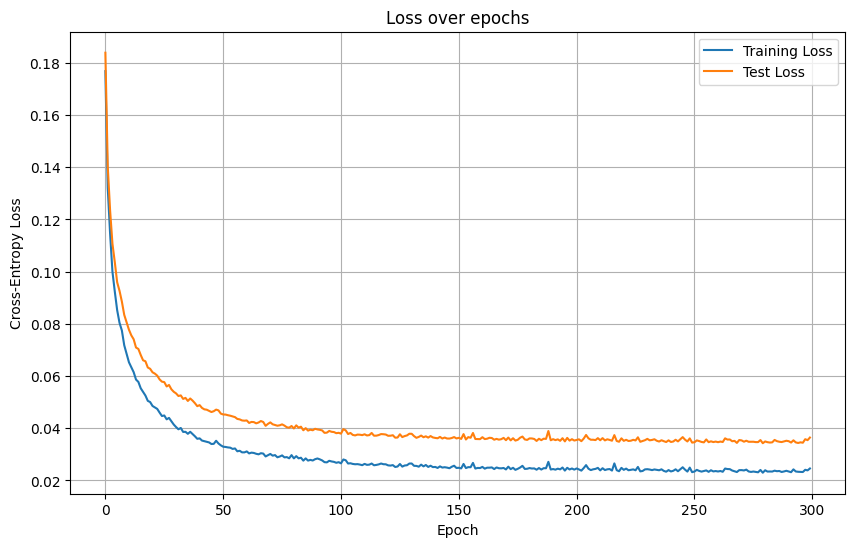

Plotting confusion matrix...


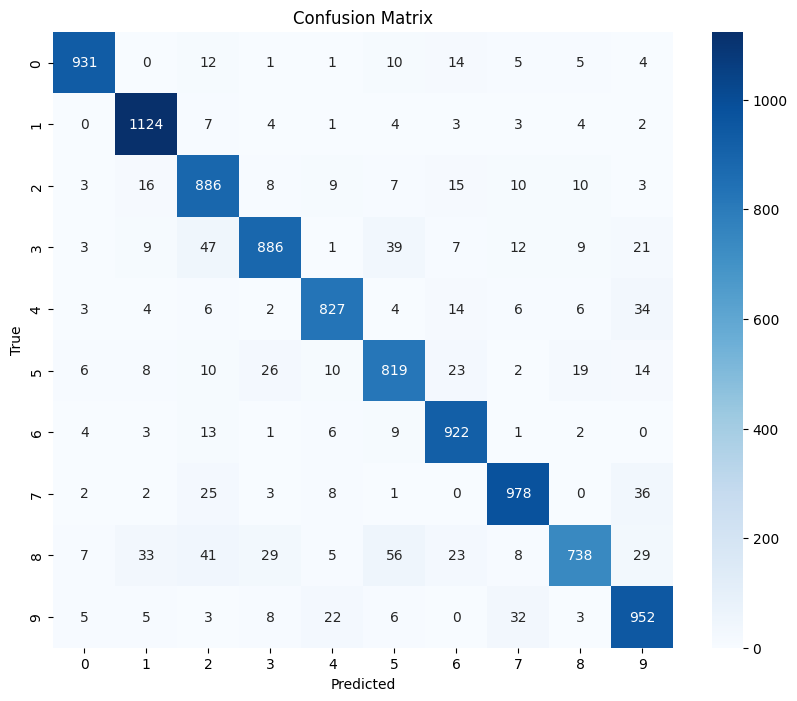

Visualizing model weights for each digit class...


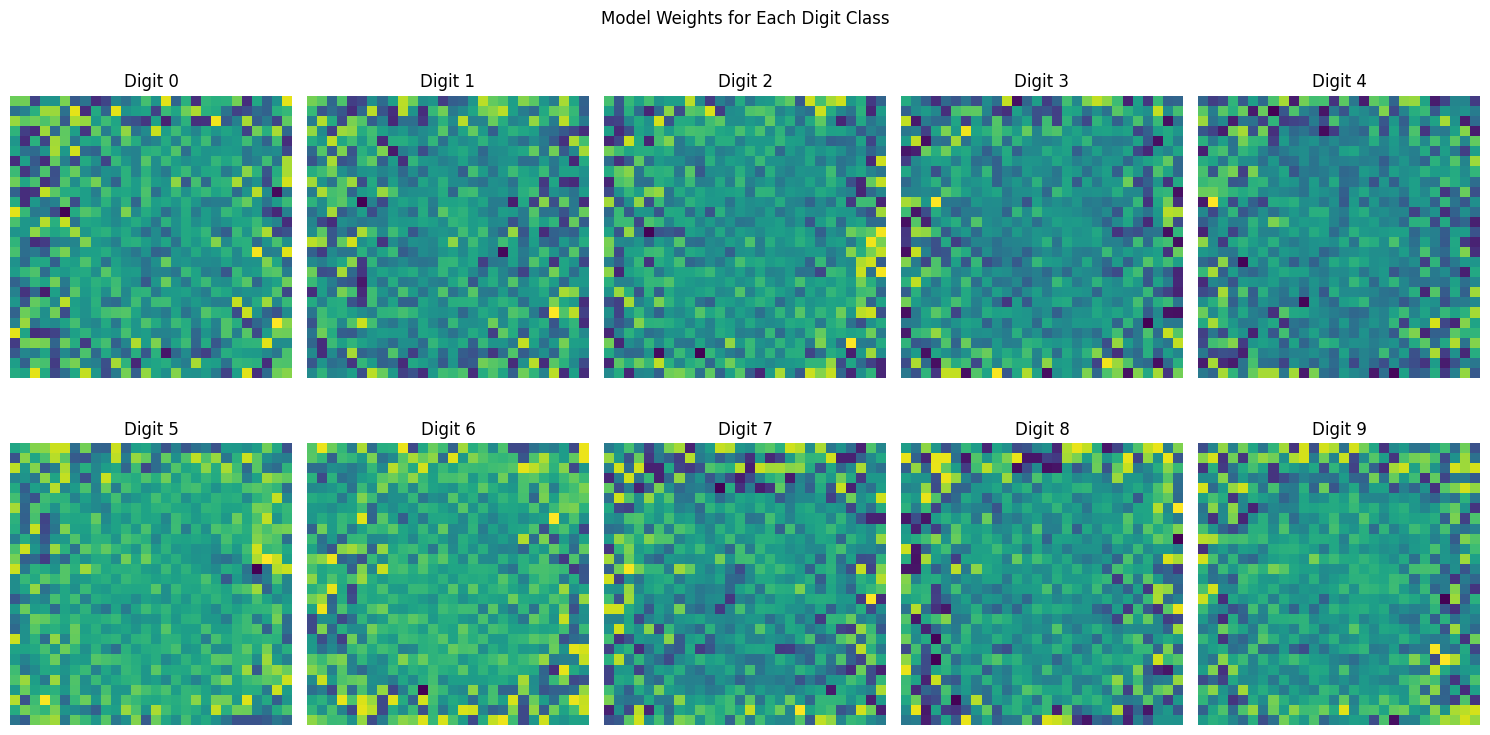

Analyzing most common misclassifications...

Top 5 most common misclassifications:
True digit 8 classified as 5: 56 times
True digit 3 classified as 2: 47 times
True digit 8 classified as 2: 41 times
True digit 3 classified as 5: 39 times
True digit 7 classified as 9: 36 times

Analyzing model convergence...
Final training loss: 0.0246
Final test loss: 0.0364
Absolute difference: 0.0119
The model appears to have converged well.

===== Summary =====
Model: Logistic Regression with Softmax
Dataset: MNIST (60,000 training samples, 10,000 test samples)
Learning rate: 1e-05
Epochs: 300
Batch size: 128
Final accuracy: 0.9063
Average sensitivity: 0.9050
Training complete!


In [26]:
# Create and train the model
print("Creating and training the model...")
model = LogisticRegression(
    input_dim=X_train.shape[1],  # 785 (784 features + 1 bias)
    num_classes=10,              # 10 digit classes
    learning_rate=0.00001           # Research-based learning rate
)

# Train the model with mini-batch gradient descent
train_loss, test_loss, conf_matrix = model.fit(
    X_train, y_train_onehot,
    X_test, y_test_onehot,
    epochs=300,                  # 50 epochs
    batch_size=128,             # Mini-batch size of 128
    verbose=True
)

# Calculate evaluation metrics
metrics = model.compute_metrics(conf_matrix)
accuracy = metrics['accuracy']
sensitivity = metrics['sensitivity']

# Display results
print("\n===== Model Performance =====")
print(f"Accuracy: {accuracy:.4f}")
print("\nSensitivity (TPR) for each digit:")
for i, sens in enumerate(sensitivity):
    print(f"Digit {i}: {sens:.4f}")

# Visualize learning curves
print("\nPlotting learning curves...")
model.plot_loss_history()

# Visualize confusion matrix
print("Plotting confusion matrix...")
model.plot_confusion_matrix(conf_matrix)

# Visualize model weights
print("Visualizing model weights for each digit class...")
weights = model.get_W()
feature_weights = weights[:-1]  # Exclude bias weights

# Reshape weights to visualize as images (28x28)
plt.figure(figsize=(15, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    weight_img = feature_weights[:, i].reshape(28, 28)
    plt.imshow(weight_img, cmap='viridis')
    plt.title(f"Digit {i}")
    plt.axis('off')
plt.suptitle("Model Weights for Each Digit Class")
plt.tight_layout()
plt.show()

# Analyze misclassifications
print("Analyzing most common misclassifications...")
# Find top 5 most common misclassifications
misclassifications = []
for i in range(10):
    for j in range(10):
        if i != j:  # Skip the diagonal (correct classifications)
            misclassifications.append((i, j, conf_matrix[i, j]))

# Sort by count in descending order
misclassifications.sort(key=lambda x: x[2], reverse=True)

# Display top 5 most common misclassifications
print("\nTop 5 most common misclassifications:")
for true_digit, pred_digit, count in misclassifications[:5]:
    print(f"True digit {true_digit} classified as {pred_digit}: {count} times")

# Analyze model convergence
print("\nAnalyzing model convergence...")
# Check if the model has converged
final_train_loss = train_loss[-1]
final_test_loss = test_loss[-1]
loss_diff = abs(final_train_loss - final_test_loss)
print(f"Final training loss: {final_train_loss:.4f}")
print(f"Final test loss: {final_test_loss:.4f}")
print(f"Absolute difference: {loss_diff:.4f}")

if loss_diff > 0.1:
    print("The model shows signs of overfitting (test loss significantly higher than training loss).")
elif final_train_loss > 0.3:
    print("The model may be underfitting (high training loss).")
else:
    print("The model appears to have converged well.")

# Final summary
print("\n===== Summary =====")
print(f"Model: Logistic Regression with Softmax")
print(f"Dataset: MNIST (60,000 training samples, 10,000 test samples)")
print(f"Learning rate: {model.learning_rate}")
print(f"Epochs: {len(train_loss)}")
print(f"Batch size: 128")
print(f"Final accuracy: {accuracy:.4f}")
print(f"Average sensitivity: {np.mean(sensitivity):.4f}")
print("Training complete!")